In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv as csv
import networkx as nx
import pandas as pd
from tqdm import tqdm

import csv

import os

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import plot_style, util, network_model

In [2]:
timing = 0.5
trial_duration = 6
dt = 1e-5

In [5]:
MIN_WIDTH = 1578    # in pixels at 600 dpi
MAX_WIDTH = 4500
MAX_HEIGHT = 5250

inh_blue = "#7879ff"
excit_red = '#F58E89'

In [3]:
def bistable_no_depression(pset, stimulus_timing, stimulus_duration, stimulus_amplitude, duration, dt, initial_conditions=[0, 0]):
    rmax = 100
    tauE, tauI, _, _, _, _, _, _, WEE, WEI, WIE, WII, thetaE, thetaI = network_model.unpack_parameters(pset)
    
    IappI = np.zeros(int(duration/dt))
    IappE = np.zeros(int(duration/dt))
    IappE[int(stimulus_timing/dt):int((stimulus_timing+stimulus_duration)/dt)] = stimulus_amplitude
    IappI[int(stimulus_timing/dt):int((stimulus_timing+stimulus_duration)/dt)] = stimulus_amplitude

    rE, rI = network_model.simulateISP(dt, duration, rmax, tauE, tauI, 
                            WEE, WEI, WIE, WII, thetaE, thetaI,
                            IappI, IappE, rE0=initial_conditions[0], rI0=initial_conditions[1])   
    
    return rE, rI

In [51]:
def plot_trace(ax, traces, duration=2, dt = 1e-5, x_max=2, y_max=20, x_min=0, dur = 0):
    time = np.arange(0, duration, dt)
    ax.plot(time-timing, traces[0], label=r'$r_E$', c=excit_red)
    ax.plot(time-timing, traces[1], label=r'$r_I$', c=inh_blue)
    ax.set_xlabel('Time (s)')
    ax.set(xlim = (x_min,x_max), ylim=(0,y_max))
    ax.axvspan(0, dur, alpha=0.75, color='0.8')

In [7]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        start_ind = len(xdata) // 2
    else:
        start_ind = int(len(xdata) * position)
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )

In [41]:
def get_basins(pset, amplitude, n=500, rE_max=50, rI_max=50):
    dt = 1e-4

    # meshgrid for initial conditions
    x = np.linspace(0, rE_max, n) # rE0
    y = np.linspace(0, rI_max, n) # rI0
    X, Y = np.meshgrid(x, y)
    X_, Y_ = X.ravel(), Y.ravel()

    # find final states for each initial condition
    final_states = np.zeros((n*n, 2))
    duration = 24
    for j, (rE0, rI0) in enumerate(zip(X_, Y_)):
        rE, rI = bistable_no_depression(pset, 0, duration, amplitude, duration, dt, initial_conditions=[rE0, rI0])
        final_states[j] = [rE[-1], rI[-1]]
        
    # find unique steady states
    steady_states, indices = np.unique(np.round(final_states,1), axis=0, return_index=True)
    steady_states = final_states[indices]
    
    # map final states to steady states for colormap
    color_mappings = np.ones((n*n))*-1 # will break the colormap if any -1s are left (intended behavior)
    for i, state in enumerate(final_states):
        for j, steady_state in enumerate(steady_states):
            if np.allclose(state, steady_state, atol=1e-1):
                color_mappings[i] = j
    
    return X, Y, color_mappings, steady_states

In [8]:
def plot_basins(ax, X, Y, colors, states, trajectory, xmax=20, ymax=50):
    ax.contourf(X, Y, colors.reshape(X.shape), levels=len(states), cmap='Pastel1')
    ax.set(xlim=(0, xmax), ylim=(0, ymax))
    ax.plot(trajectory[0], trajectory[1], color='black')
    # add a point at the beginning and end of the trajectory
    ax.scatter(trajectory[0][0], trajectory[1][0], color='black', marker='o', zorder=10, s=20)
    ax.scatter(trajectory[0][-1], trajectory[1][-1], color='black', marker='o', zorder=10, s=20)
    # get line
    line = ax.lines[-1]
    ax.scatter(states[:, 0], states[:, 1], color='red', label='steady states', marker='x', zorder=10)
    return line

In [52]:
def make_plot(pset, amp, dur, off_to_on, on_to_off, x_max=30, y_max=30, n=20):
    X, Y, autonomous_basins, auto_states = get_basins(pset, 0, n=n, rE_max=x_max, rI_max=y_max)
    _, _, stim_basins, stim_states = get_basins(pset, amp, n=n, rE_max=x_max, rI_max=y_max)
    off_to_on = np.array(off_to_on)
    on_to_off = np.array(on_to_off)
    
    # plot
    px = 1/plt.rcParams['figure.dpi']   # convert pixel to inches
    fig = plt.figure(layout='tight', figsize=(MAX_WIDTH*px, MAX_WIDTH*px*0.6))
    axd = fig.subplot_mosaic(
        """
        AaCD
        EFGH
        """,
        height_ratios=[1, 1]
    )
    # hide axis A and I
    axd['A'].axis('off')
    axd['a'].axis('off')
    # add labels
    label_dict = {
        'A':'A1   stimulus on', 'a':'A2   stimulus off',
        'C':'B1', "D":'B2',   
        'E':'C1   stimulus on', "F":'C2   stimulus. off', 'G':'C3   stimulus. on', 'H':'C4   stimulus. off'
        }
    for label, ax in axd.items():
        ax.set_title(label_dict[label], loc='left', fontweight='bold')

    # plot standard traces ---------------------------------------------
    axd['C'].sharey(axd['D'])
    plot_trace(axd['C'], off_to_on, duration=6, x_min=-0.1, x_max = 0.1, y_max=30)
    plot_trace(axd['D'], on_to_off, duration=6, x_min=-0.1, x_max = 0.1, y_max=30)
    axd['C'].set_ylabel('Firing Rate (Hz)')
    axd['C'].legend(loc='upper left')
    axd['C'].annotate(r'$-/+$', xy=(0.775, 0.825), xycoords='axes fraction', ha='center', fontsize=18)
    axd['D'].annotate(r'$+/-$', xy=(0.775, 0.825), xycoords='axes fraction', ha='center', fontsize=18)

    # plot traces over basins -----------------------------------------------
    line = plot_basins(axd['E'], X, Y, stim_basins, stim_states, off_to_on[:, int(timing/dt):int((timing+dur)/dt)], xmax=x_max, ymax=y_max)
    # for p in np.linspace(0.5, 1, 3, endpoint=False):
    #     add_arrow(line, position=p, direction='right', size=12)
    line = plot_basins(axd['F'], X, Y, autonomous_basins, auto_states, off_to_on[:, int((timing+dur)/dt):], xmax=x_max, ymax=y_max)
    # for p in [0.0001, 0.0004, 0.0006, 0.001]:
    #     add_arrow(line, position=p, direction='right', size=12)
    line = plot_basins(axd['G'], X, Y, stim_basins, stim_states, on_to_off[:, int(timing/dt):int((timing+dur)/dt)], xmax=x_max, ymax=y_max)
    # for p in np.linspace(0.25, 1, 3, endpoint=False):
    #     add_arrow(line, position=p, direction='right', size=12)
    line = plot_basins(axd['H'], X, Y, autonomous_basins, auto_states, on_to_off[:, int((timing+dur)/dt):], xmax=x_max, ymax=y_max)
    # for p in [0.0003, 0.0005]:
    #     add_arrow(line, position=p, direction='right', size=12)
    # add annotations to basins
    annotations = [r'$-/+$', r'$-/+$', r'$+/-$', r'$+/-$']
    for ax, annotation in zip([axd['E'], axd['F'], axd['G'], axd['H']], annotations):
        ax.annotate(annotation, xy=(0.8, 0.025), xycoords='axes fraction', ha='center', fontsize=18)
    # add xlabels to basins
    for ax in [axd['E'], axd['F'], axd['G'], axd['H']]:
        ax.set_xlabel(r'$r_E (Hz)$')
    # basins share y-label
    axd['E'].set_ylabel(r'$r_I (Hz)$')

    plt.show()

In [12]:
# use figure 2 as reference data
areas = np.load('../figure2/data/areas.npy', allow_pickle=True)
det_mesh = np.load('../figure2/data/determinant_mesh.npy', allow_pickle=True)
tr_mesh = np.load('../figure2/data/trace_mesh.npy', allow_pickle=True)

areas.shape, det_mesh.shape, tr_mesh.shape

((2500,), (2500,), (2500,))

In [18]:
sort_idx = np.argsort(areas)[::-1]
sorted_det = det_mesh[sort_idx]
sorted_tr = tr_mesh[sort_idx]

0


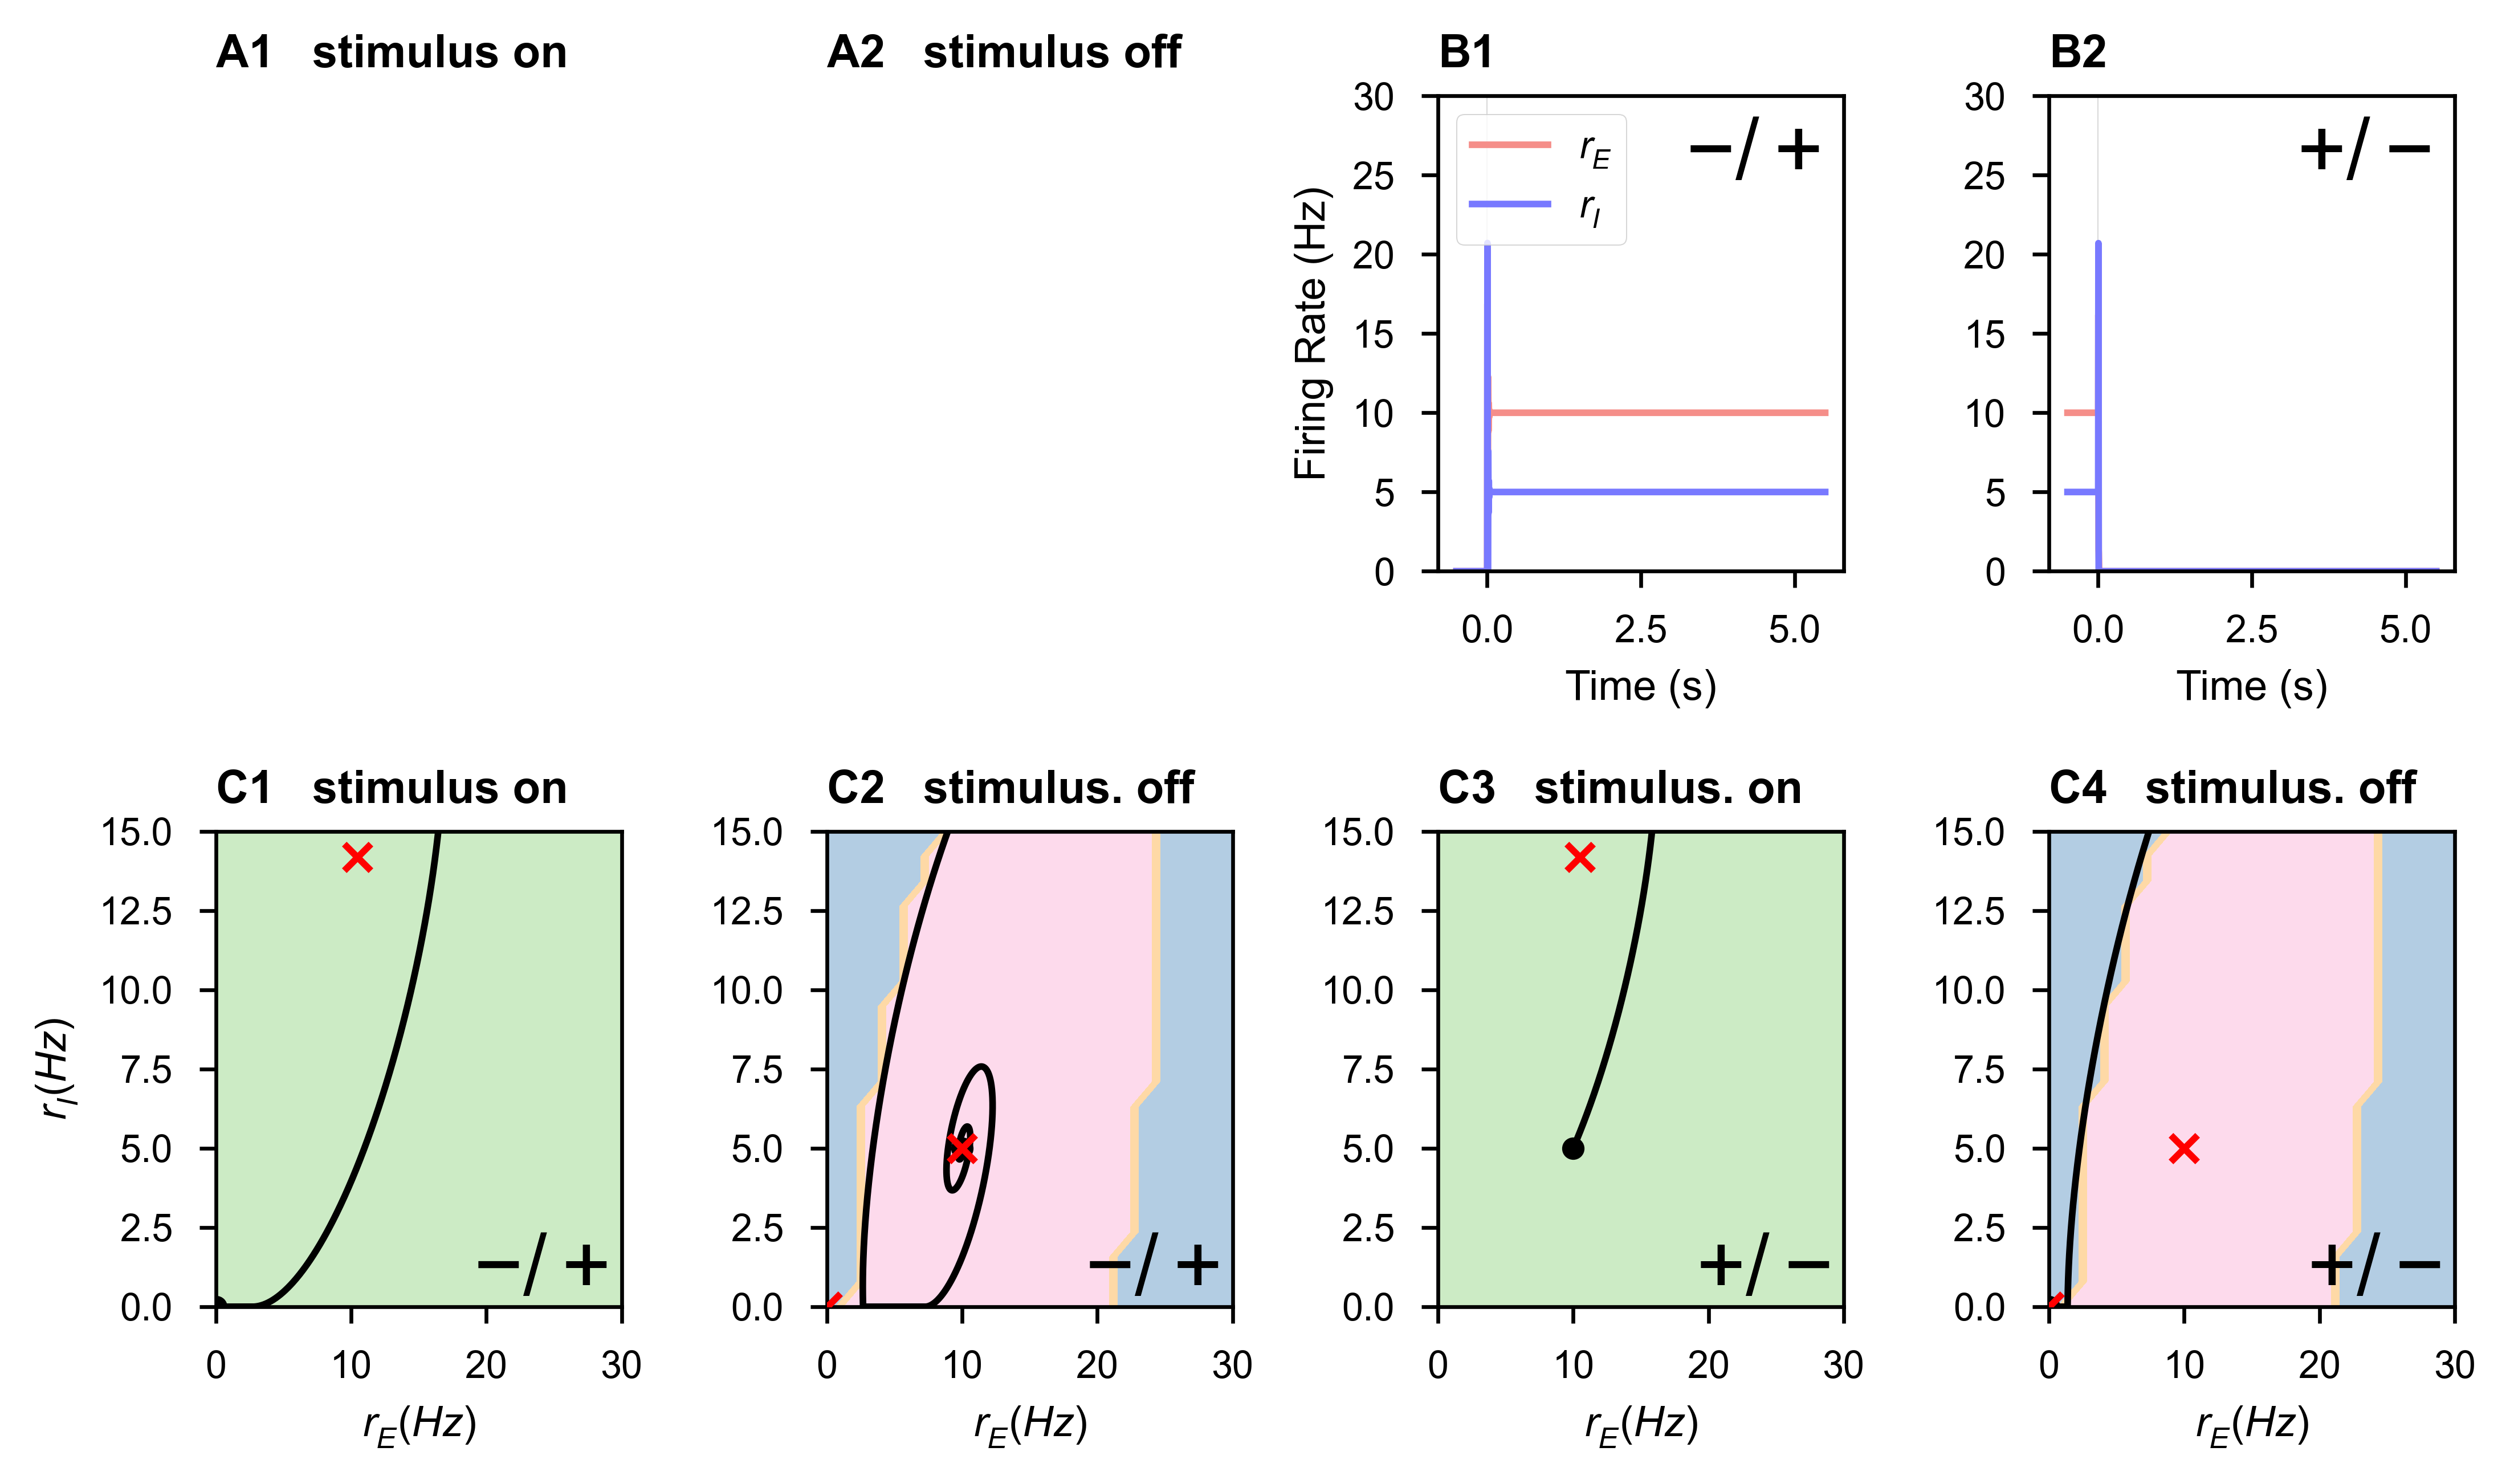

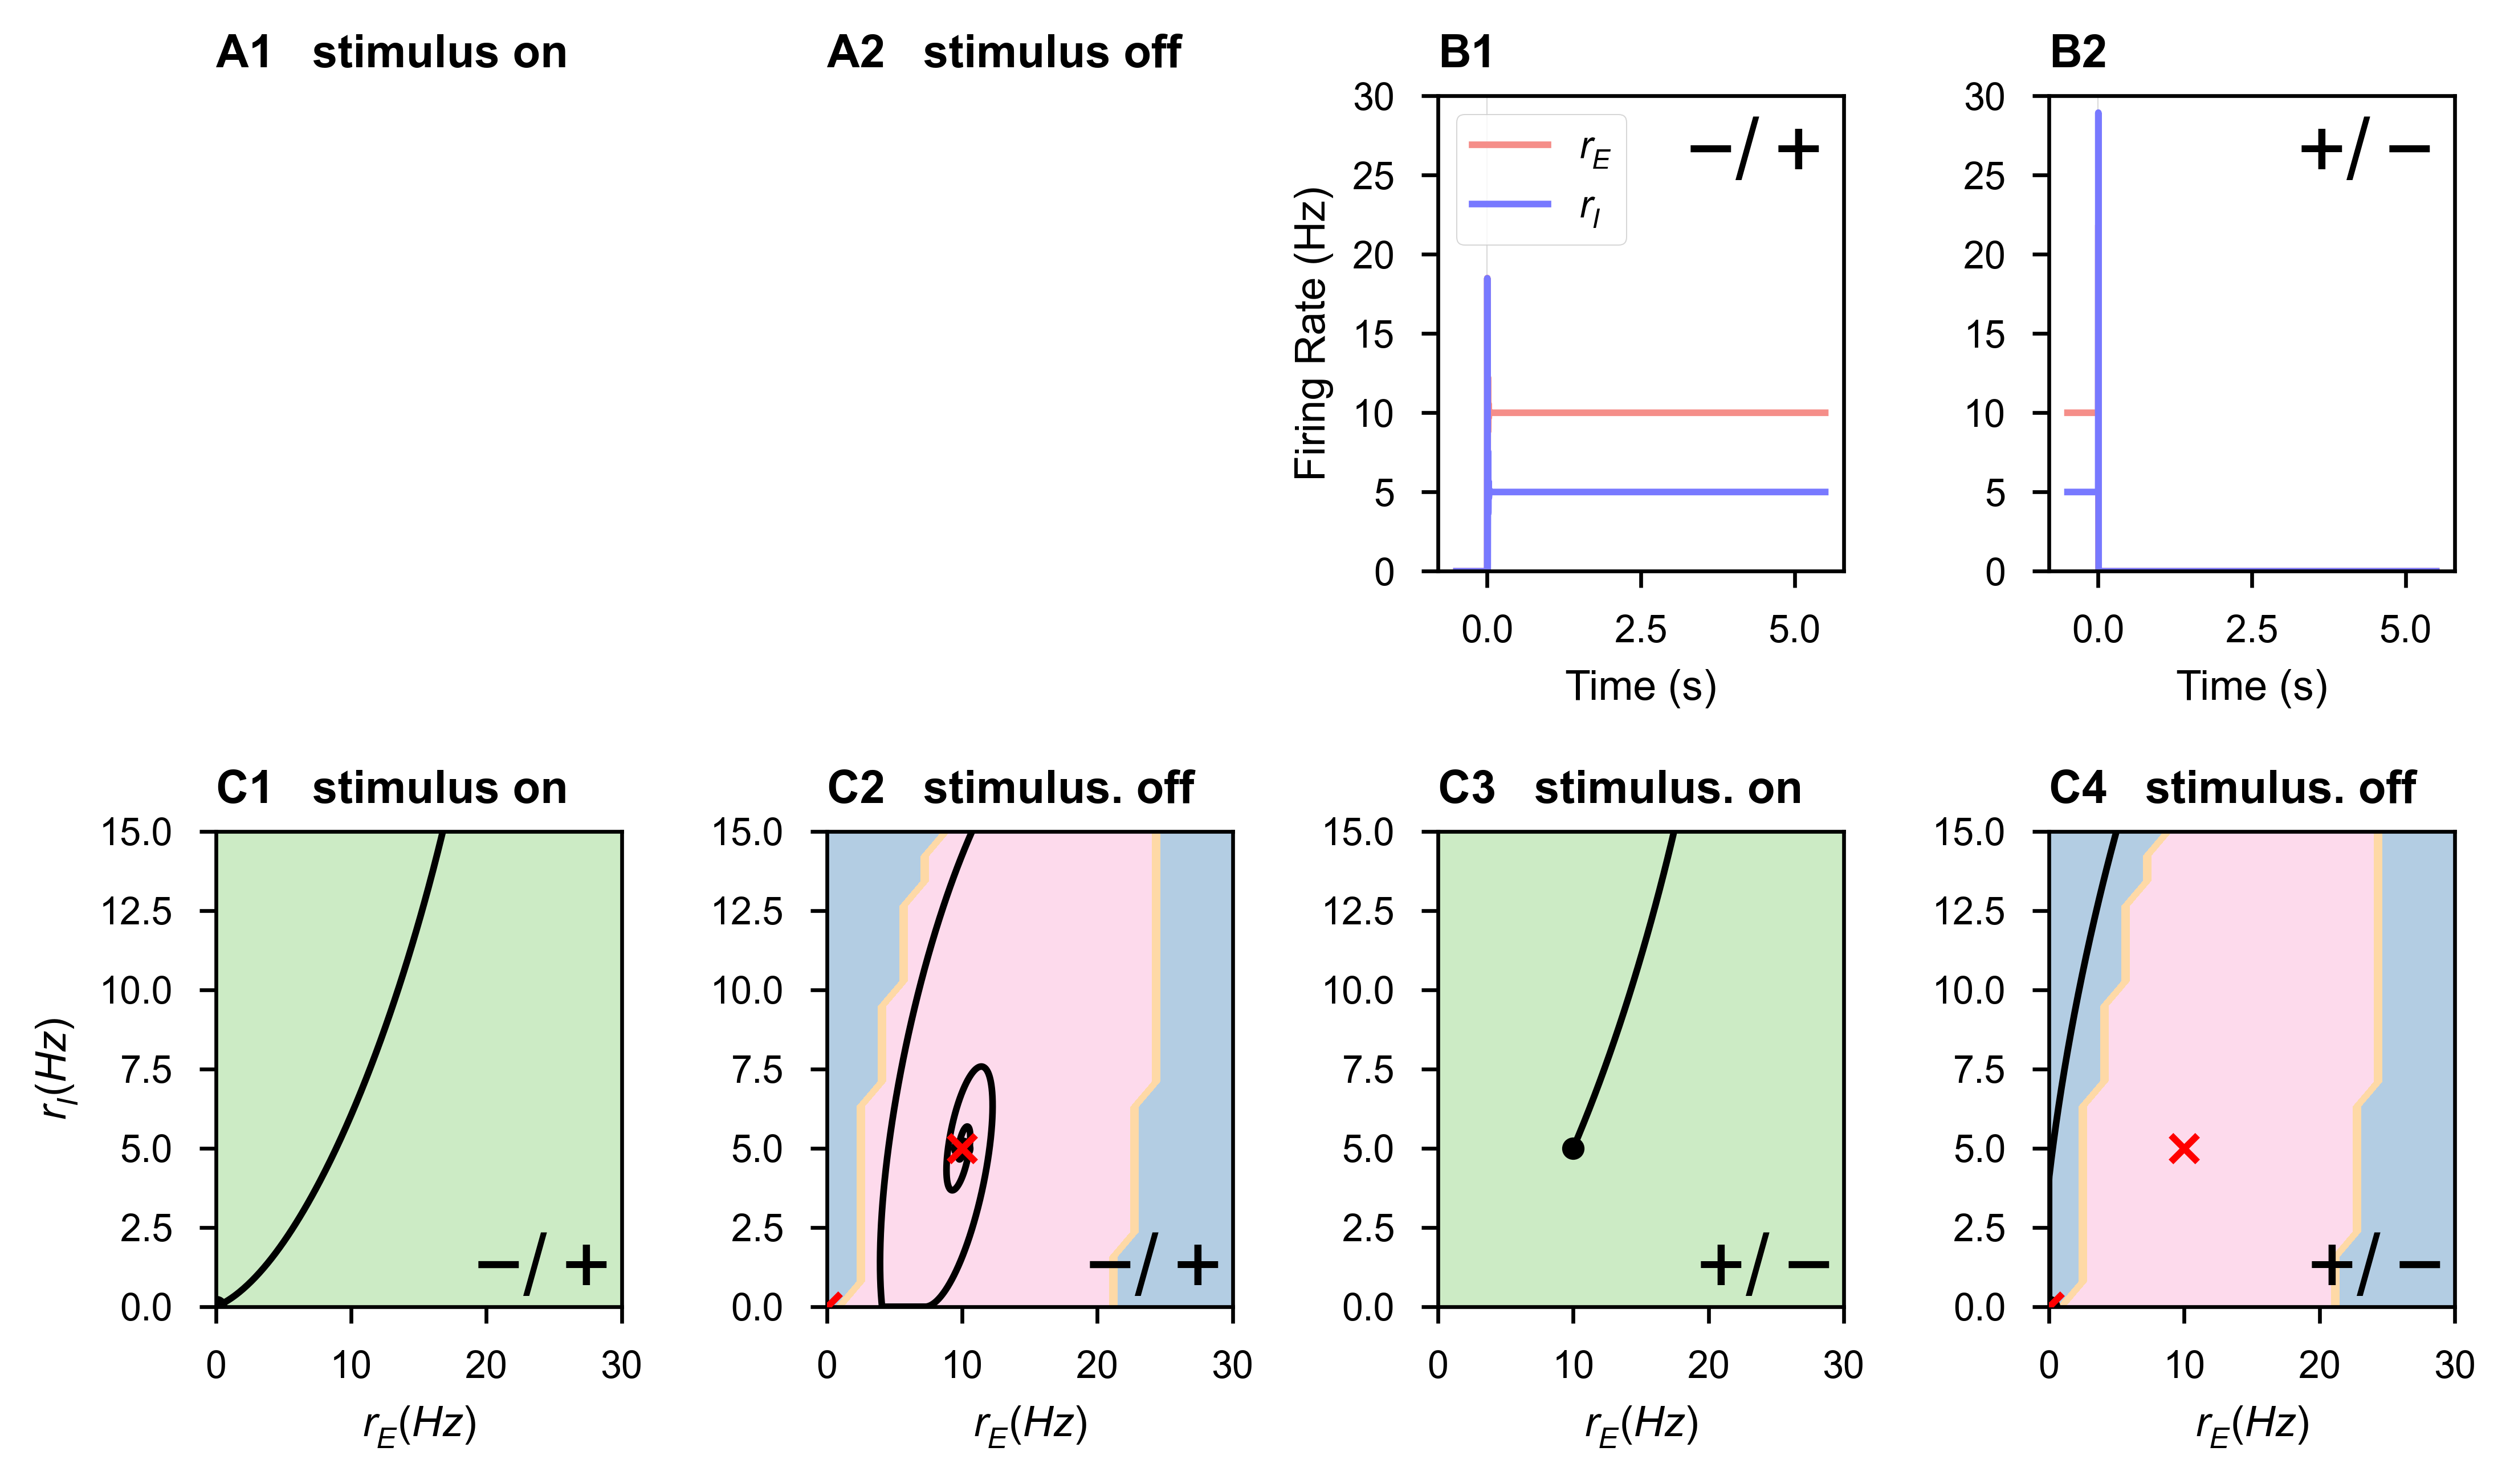

In [48]:
rE_target = 10
rI_target = 5
thetaE = 5.34
thetaI = 82.43

n_dur = n_amp = 10
stim_dur_range = np.logspace(-3, 0, n_dur).round(5)
stim_amp_range = np.logspace(np.log10(thetaE), 2, n_amp).round(2)

good_psets = []
good_amp_durs = []
start_idx = 600
for i, (tr, det) in enumerate(zip(sorted_tr[start_idx:], sorted_det[start_idx:])):
    target= util.make_target(rE_target, rI_target, tr, det, thetaE, thetaI)
    x, valid = util.get_solution(target, method='hybr')
    print(i)
    done = False
    if valid:
        pset = network_model.pack_parameters(10e-3, 10e-3, 0, 0, 0, 0, 0, 0, x[0], x[1], x[2], x[3], thetaE, thetaI)
        for amp in stim_amp_range:
            skip_pset = False
            for dur in stim_dur_range:
                off_to_on = bistable_no_depression(pset, timing, dur, amp, trial_duration, dt)
                on_to_off = bistable_no_depression(pset, timing, dur, amp, trial_duration, dt, initial_conditions=[rE_target, rI_target])
                # check stability of all nodes
                stably_on = np.all(np.abs(off_to_on[0][int((trial_duration-1)/dt):-1] - rE_target) < 0.1) \
                    and np.allclose(off_to_on[0][int((trial_duration - 0.1)/dt):], off_to_on[0][-1], atol=0.1, rtol=0)
                stably_off = np.all(on_to_off[0][int((trial_duration-1)/dt):-1] < 0.1) \
                    and np.allclose(on_to_off[0][int((trial_duration - 0.1)/dt):], on_to_off[0][-1], atol=0.1, rtol=0)

                if stably_on and stably_off:
                    make_plot(pset, amp, dur, off_to_on, on_to_off)
                    if input("Save this pset? (y/n): ").lower() == 'y':
                        good_psets.append(pset)
                        good_amp_durs.append((i, amp, dur))
                    skip_pset = input("Skip to next pset? (y/n): ").lower() == 'y'
                
                if skip_pset:
                    done = input('done? (y/n): ').lower() == 'y'
                    break
            if skip_pset:
                break
    if done:
        break

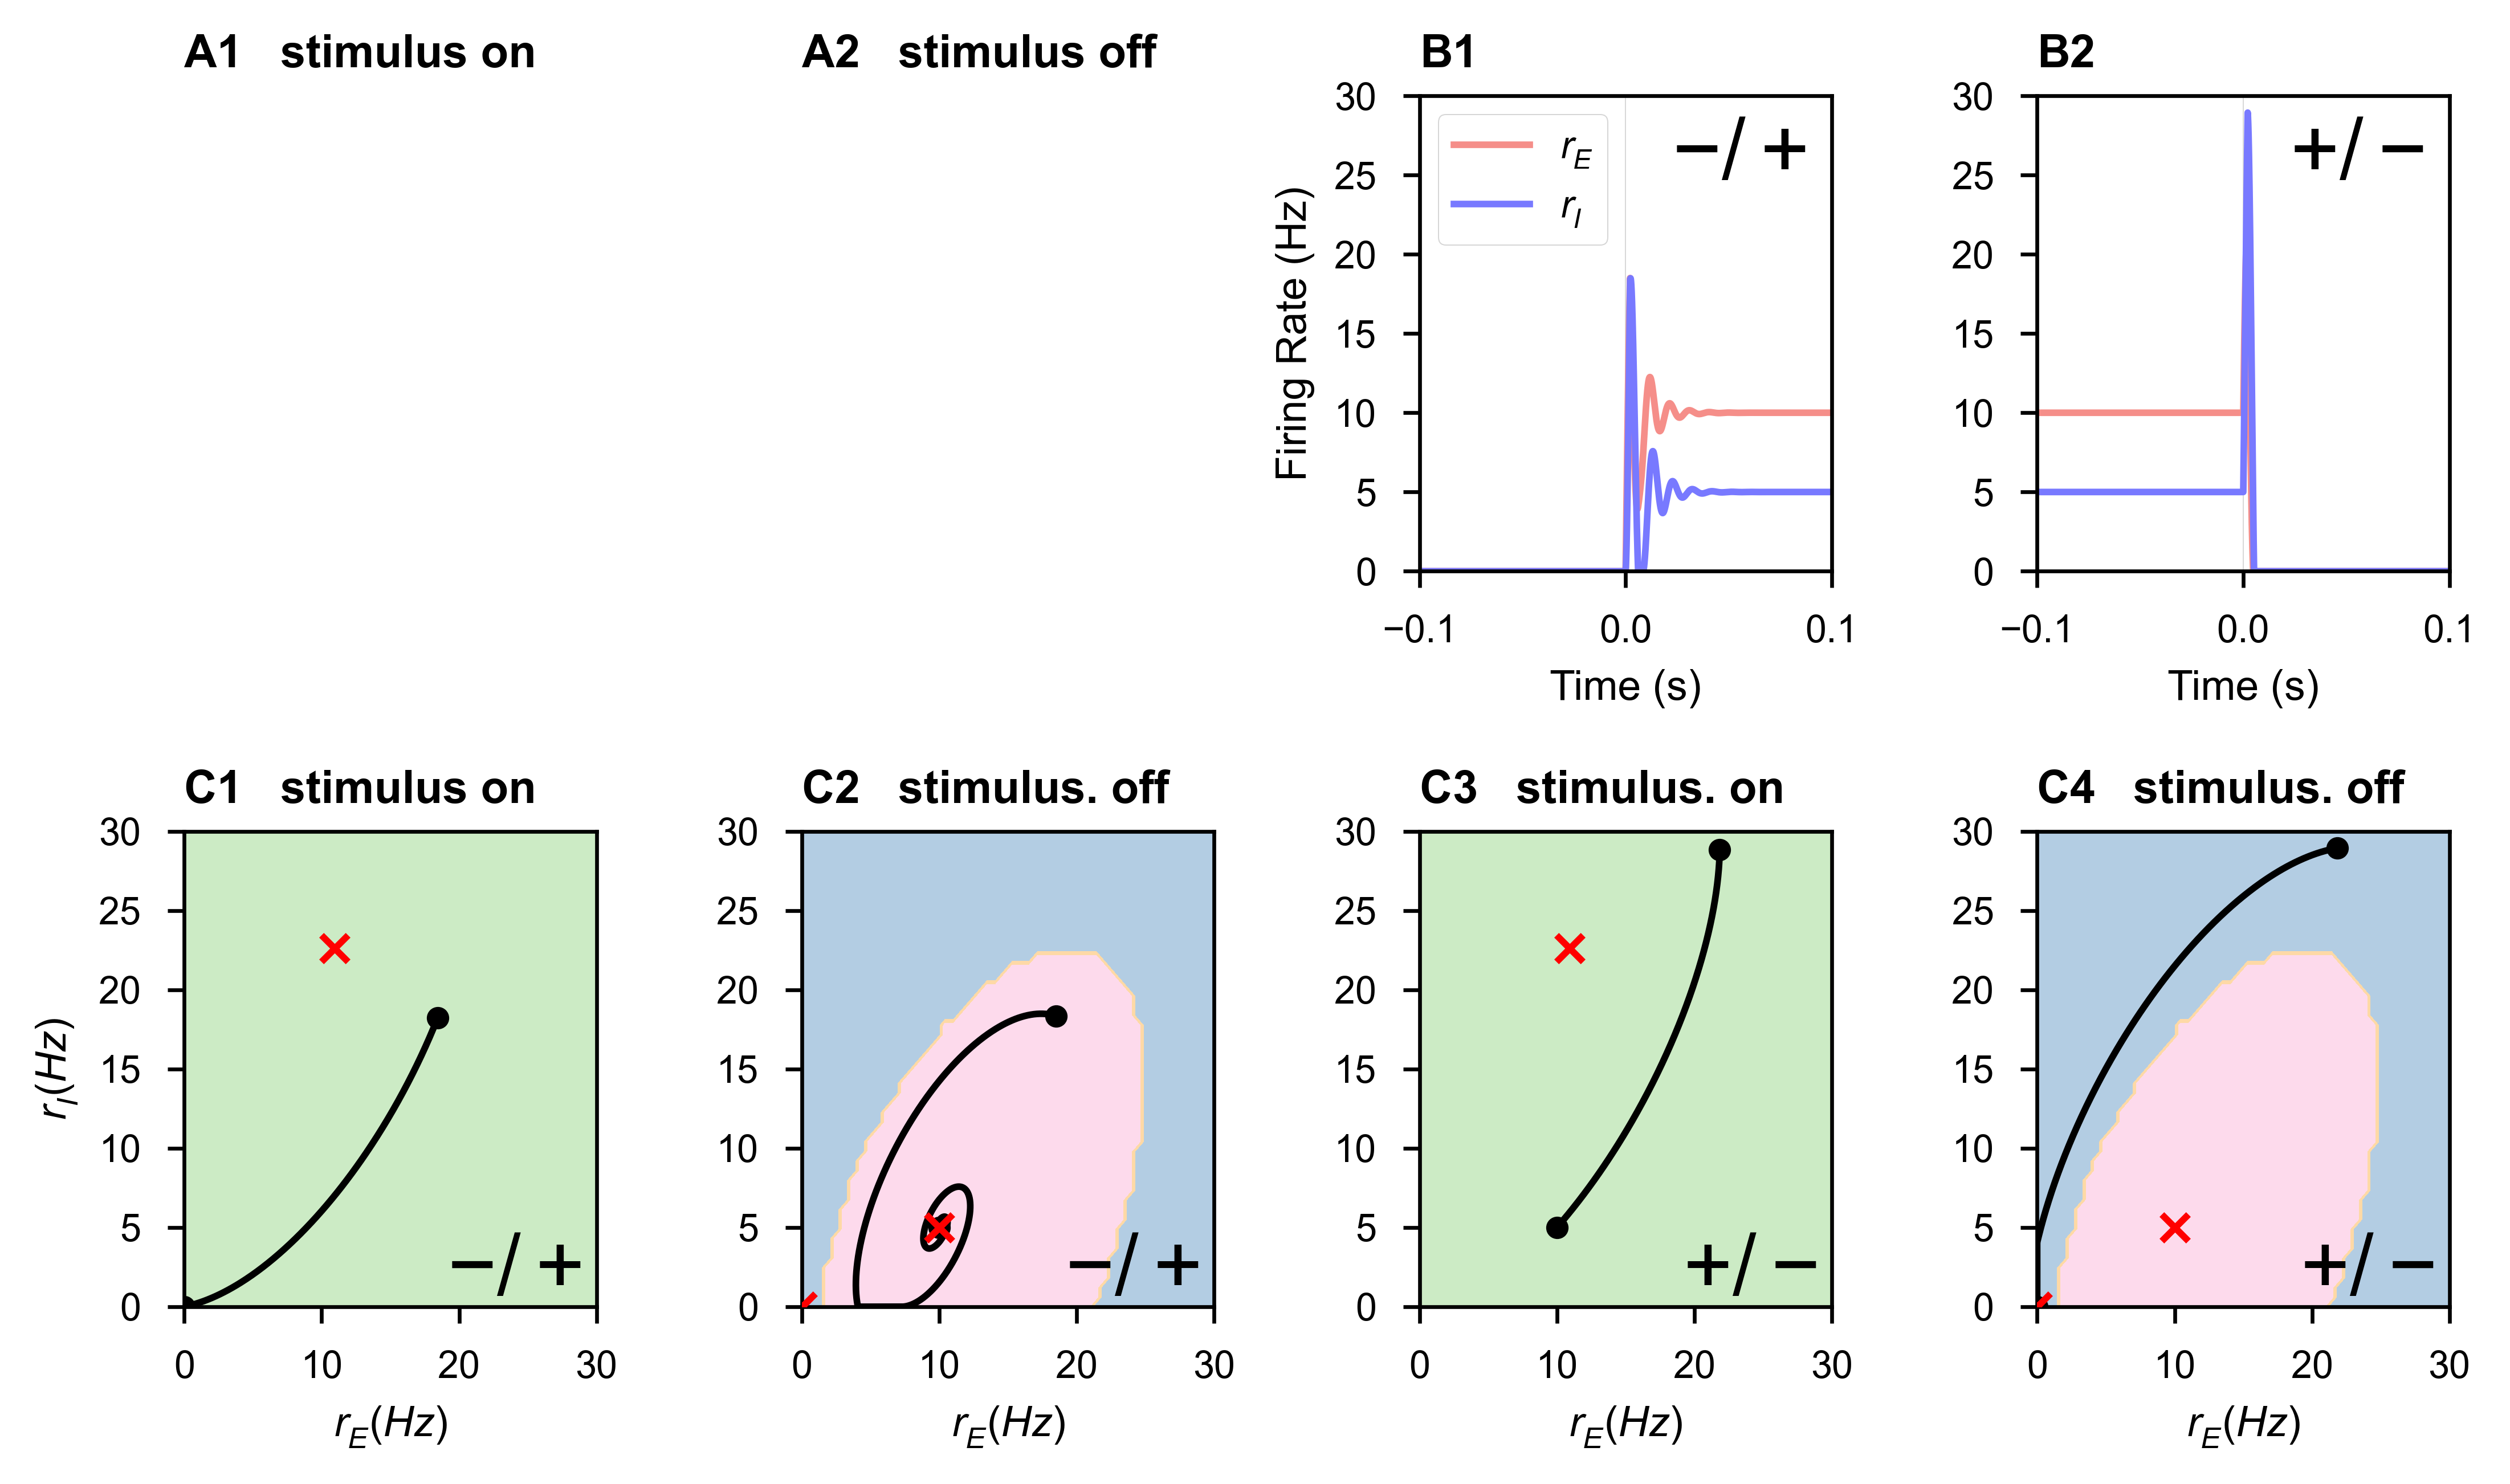

In [53]:
make_plot(good_psets[-1], good_amp_durs[-1][1], good_amp_durs[-1][2], off_to_on, on_to_off, n=50)